In [636]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
import wandb

config = {
    "lr": 0.005,
    "lr_reduce": 0,
    "epochs": 100,
    "normalization": "max_div",
    "optimizer": 'Adam',
    "batch_size": 8,
    "layers": [{
        "nodes": 100,
        "activation": "relu",
        "W_init_type": "GlorotNormal",
        "b_init_type": "zeros",
    },{
        "nodes": 10,
        "activation": "relu",
        "W_init_type": "GlorotNormal",
        "b_init_type": "zeros",
    }]
}

In [637]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.__version__, np.__version__, plt.__name__

('2.8.0', '1.21.0', 'matplotlib.pyplot')

In [638]:
X_train_tf = tf.data.Dataset.from_tensor_slices(X_train)
y_train_tf = tf.data.Dataset.from_tensor_slices(y_train)
X_test_tf = tf.data.Dataset.from_tensor_slices(X_test)
y_test_tf = tf.data.Dataset.from_tensor_slices(y_test)

In [639]:
type(next(iter(X_test_tf)))
unique = set()
for i in y_train_tf:
    unique.add(i.numpy())
label_size = len(unique)
label_size, unique

(10, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

In [640]:
X_train_tf_n = X_train_tf.map(lambda x: x/255)
X_train_tf_n = X_train_tf_n.map(lambda x: tf.reshape(x, [-1,]))
X_test_tf_n = X_test_tf.map(lambda x: x/255)
X_test_tf_n = X_test_tf_n.map(lambda x: tf.reshape(x, [-1,]))

In [641]:
next(iter(X_train_tf_n)).numpy().shape, X_train_tf_n.element_spec

((784,), TensorSpec(shape=(784,), dtype=tf.float32, name=None))

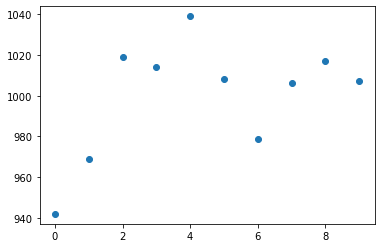

In [642]:
import math
data = []
y = [0 for i in range(10)]
for i in range(10000):
    value = tf.random.uniform((1,)).numpy()[0]
    y[math.floor(value*10)] += 1
plt.scatter([i for i in range(10)], y)

In [643]:
y_train_tf_oh = y_train_tf.map(lambda x: tf.one_hot(x, depth=label_size, axis=0))
y_train_tf_oh = y_train_tf.map(lambda x: tf.one_hot(x, depth=label_size, axis=0))
next(iter(y_train_tf_oh))

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)>

In [644]:
from tqdm import tqdm
from datetime import timedelta
from wandb import AlertLevel
def model(X_train, y_train, X_test, y_test, learning_rate=0.1, epochs=1, batch_size=32, print_cost=True, layers_config=[]):
    wandb.init(project="mnist", entity="kaizen", config = config)
    layers = [x['nodes'] for x in layers_config]
    parameters = []
    train_acc = []
    test_acc = []
    costs = []
    # creating parameters
    input_nodes = next(iter(X_train)).numpy().shape[0]
    initializer = tf.keras.initializers.GlorotNormal()
    for layer_n in range(1, len(layers) + 1):
        prv_layer = layers[layer_n - 2] if layer_n>1 else input_nodes
        cur_layer = layers[layer_n - 1]
        parameters.append(tf.Variable(initializer((cur_layer, prv_layer))))
        parameters.append(tf.Variable(tf.zeros((cur_layer, 1))))
    # created parameters
    
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    train_dataset = tf.data.Dataset.zip((X_train, y_train))
    
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    test_dataset = tf.data.Dataset.zip((X_test, y_test))
    
    m = train_dataset.cardinality().numpy()
    
    train_batches = train_dataset.batch(batch_size).prefetch(8)
    test_batches = test_dataset.batch(batch_size).prefetch(8)
    
    def forward_prop(data):
        prv = data
        for n_layer in range(len(layers)):
            Z = tf.add(tf.matmul(parameters[n_layer * 2], prv), parameters[n_layer*2+1])
            a = tf.keras.activations.relu(Z)
            prv = a
        return prv
    
    for epoch in tqdm(range(epochs)):
        epoch_cost = 0
        train_accuracy.reset_states()
        for (X_train_batch, y_train_batch) in train_batches:
            prv = tf.transpose(X_train_batch)
            with tf.GradientTape() as tape:
                pred = forward_prop(prv)
                loss = tf.keras.losses.categorical_crossentropy(y_train_batch, tf.transpose(pred), from_logits=True)
                batch_cost = tf.reduce_mean(loss)
            # print(batch_cost)
            grads = tape.gradient(batch_cost, parameters)
            optimizer.apply_gradients(zip(grads, parameters))
            epoch_cost += batch_cost
            train_accuracy.update_state(tf.transpose(pred), y_train_batch)
        epoch_cost /= m
        costs.append(epoch_cost)
        if epoch%2==0:
            test_accuracy.reset_states()
            for (X_test_batch, y_test_batch) in test_batches:
                test_accuracy.update_state(tf.transpose(forward_prop(tf.transpose(X_test_batch))), y_test_batch)
            acc = test_accuracy.result()
            # print('test =', acc)
            test_acc.append(acc)
            wandb.log({
                "test_accuracy": acc,
            })
        acc = train_accuracy.result()
        wandb.log({
            'loss': epoch_cost,
            'learning_rate': learning_rate,
            'epoch': epoch,
            "train_accuracy": acc,
        })
        # print('train =', acc)
        # print(epoch_cost)
        train_acc.append(acc)
    wandb.alert(
        title='Experiment Completed',
        text=f'Accuracy train:{train_acc[-1]} test:{test_acc[-1]}',
        level=AlertLevel.WARN,
        wait_duration=timedelta(minutes=0)
    )
    return parameters, costs, train_acc, test_acc

In [645]:
parameters, costs, train_acc, test_acc = model(X_train_tf_n, y_train_tf_oh, X_test_tf_n, y_test_tf_oh, epochs=config['epochs'], learning_rate=config['lr'], layers_config=config['layers'])

Problem at: /var/folders/tq/wb4jkksx6h17_7ldcd1p_f8c0000gp/T/ipykernel_46415/4142610292.py 5 model


Traceback (most recent call last):
  File "/Users/tnluser/opt/anaconda3/lib/python3.9/site-packages/wandb/sdk/wandb_init.py", line 999, in init
    run = wi.init()
  File "/Users/tnluser/opt/anaconda3/lib/python3.9/site-packages/wandb/sdk/wandb_init.py", line 494, in init
    self._wl._global_run_stack[-1].finish()
  File "/Users/tnluser/opt/anaconda3/lib/python3.9/site-packages/wandb/sdk/wandb_run.py", line 256, in wrapper
    return func(self, *args, **kwargs)
  File "/Users/tnluser/opt/anaconda3/lib/python3.9/site-packages/wandb/sdk/wandb_run.py", line 222, in wrapper
    return func(self, *args, **kwargs)
  File "/Users/tnluser/opt/anaconda3/lib/python3.9/site-packages/wandb/sdk/wandb_run.py", line 1678, in finish
    return self._finish(exit_code, quiet)
  File "/Users/tnluser/opt/anaconda3/lib/python3.9/site-packages/wandb/sdk/wandb_run.py", line 1684, in _finish
    tel.feature.finish = True
  File "/Users/tnluser/opt/anaconda3/lib/python3.9/site-packages/wandb/sdk/lib/telemetry

Exception: problem

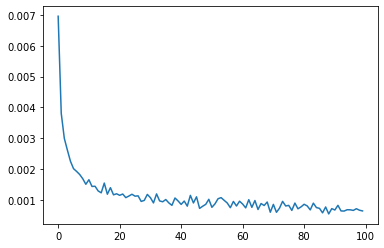

In [581]:
plt.plot(costs)

[<tf.Tensor: shape=(), dtype=float32, numpy=0.9968167>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9968167>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.99686664>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.99693334>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.99691665>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9972>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.99726665>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9968167>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9971>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9973>]

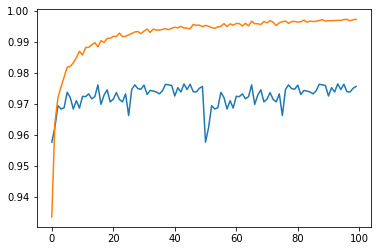

In [584]:
plt.plot(test_acc*2), plt.plot(train_acc)
train_acc[-10:]